## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import BertTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from text_cleaning import *
from bert import CustomBert3
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
def get_site(url):
    return url.split('.')[0].split('/')[-1]

train['site'] = train['url'].apply(get_site)
code_site = train['site'].isin(['stackoverflow', 'codereview', 'superuser', 'programmers'])

train.loc[code_site, 'question_body'] = train.loc[code_site, 'question_body'].apply(replace_php_xml_code_to_tag)
train.loc[code_site, 'question_body'] = train.loc[code_site, 'question_body'].apply(replace_code_block)
train.loc[code_site, 'answer'] = train.loc[code_site, 'answer'].apply(replace_php_xml_code_to_tag)
train.loc[code_site, 'answer'] = train.loc[code_site, 'answer'].apply(replace_code_block)

test['site'] = test['url'].apply(get_site)
code_site = test['site'].isin(['stackoverflow', 'codereview', 'superuser', 'programmers'])

test.loc[code_site, 'question_body'] = test.loc[code_site, 'question_body'].apply(replace_php_xml_code_to_tag)
test.loc[code_site, 'question_body'] = test.loc[code_site, 'question_body'].apply(replace_code_block)
test.loc[code_site, 'answer'] = test.loc[code_site, 'answer'].apply(replace_php_xml_code_to_tag)
test.loc[code_site, 'answer'] = test.loc[code_site, 'answer'].apply(replace_code_block)

In [4]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.add_tokens([CODE_TOKEN, PHP_TOKEN])

seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



CPU times: user 29.6 s, sys: 221 ms, total: 29.8 s
Wall time: 30 s


In [5]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [8]:
num_workers = 10
bs = 2

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [10]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_7'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Wed Feb  5 19:29:54 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


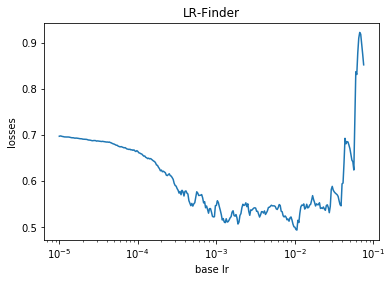

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50987 - spearmanr 0.2434
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47598 - spearmanr 0.37259
best model: epoch 0 - 0.37259
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45606 - spearmanr 0.3969
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46274 - spearmanr 0.39659
best model: epoch 1 - 0.39659
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43211 - spearmanr 0.46019
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4584 - spearmanr 0.40089
best model: epoch 2 - 0.40089
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41032 - spearmanr 0.5144
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46104 - spearmanr 0.40256
best model: epoch 3 - 0.40256
TRAINING END: Best score achieved on epoch 3 - 0.40256
Starting inference for model: checkpoints/siamese_bert_7_fold_1_best.pth



Averaged Val. score: 0.4025609383037244
Starting inference for model: checkpoints/siamese_bert_7_fold_1_best.pth



Fold 2 started at Wed Feb  5 20:10:30 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50863 - spearmanr 0.24735
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46897 - spearmanr 0.364
best model: epoch 0 - 0.364
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45581 - spearmanr 0.39757
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4563 - spearmanr 0.39143
best model: epoch 1 - 0.39143
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43228 - spearmanr 0.46086
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4602 - spearmanr 0.38747
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41043 - spearmanr 0.51585
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46031 - spearmanr 0.39129
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39143
Starting inference for model: checkpoints/siamese_bert_7_fold_2_best.pth



Averaged Val. score: 0.3914336384109883
Starting inference for model: checkpoints/siamese_bert_7_fold_2_best.pth



Fold 3 started at Wed Feb  5 20:50:02 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50924 - spearmanr 0.24732
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46093 - spearmanr 0.38152


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38152
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4569 - spearmanr 0.39563
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45044 - spearmanr 0.40072
best model: epoch 1 - 0.40072
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43305 - spearmanr 0.45983
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44713 - spearmanr 0.40944
best model: epoch 2 - 0.40944
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41139 - spearmanr 0.51266
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44987 - spearmanr 0.41127
best model: epoch 3 - 0.41127
TRAINING END: Best score achieved on epoch 3 - 0.41127
Starting inference for model: checkpoints/siamese_bert_7_fold_3_best.pth



Averaged Val. score: 0.41127222442511346
Starting inference for model: checkpoints/siamese_bert_7_fold_3_best.pth



Fold 4 started at Wed Feb  5 21:29:24 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50939 - spearmanr 0.24395
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47298 - spearmanr 0.39264
best model: epoch 0 - 0.39264
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45567 - spearmanr 0.39367
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45799 - spearmanr 0.42517
best model: epoch 1 - 0.42517
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43146 - spearmanr 0.45942
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45896 - spearmanr 0.42652
best model: epoch 2 - 0.42652
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40995 - spearmanr 0.51229
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46243 - spearmanr 0.42562
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42652
Starting inference for model: checkpoints/siamese_bert_7_fold_4_best.pth



Averaged Val. score: 0.4265204941204511
Starting inference for model: checkpoints/siamese_bert_7_fold_4_best.pth



Fold 5 started at Wed Feb  5 22:08:29 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50995 - spearmanr 0.24469
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46863 - spearmanr 0.36399
best model: epoch 0 - 0.36399
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45607 - spearmanr 0.39707
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46048 - spearmanr 0.38617
best model: epoch 1 - 0.38617
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43156 - spearmanr 0.46118
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45649 - spearmanr 0.39641
best model: epoch 2 - 0.39641
epoch 3: 	 Start training...


In [ ]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1], head_dropout=0.2)
    model.bert.resize_token_embeddings(len(tokenizer))
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))
#     scheduler = transformers.get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=2736, num_training_steps=n_epochs*2736+1)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [ ]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

In [ ]:
np.array(opt_ds), np.array(opt_indices)

In [ ]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [ ]:
get_cvs(oofs, y, ix)

In [ ]:
get_cvs(oofs_alt, y, ix)

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()

In [ ]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [ ]:
pd.DataFrame(oofs, columns=TARGETS)

In [ ]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

In [ ]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

In [ ]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

In [ ]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

In [ ]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')